# Importing Packages

In [25]:
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras.utils.vis_utils import plot_model
from keras import backend as K 
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

In [57]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_core.keras import Model
tf.random.Generator = None
import tensorflow_addons as tfa
from tensorflow.keras.layers import Flatten

# Importing data
We import the image data and the corresponding ground truth segmentation images. Follow the requirement, I use ISIC-18 dataset provided by tutor.

In [27]:
input_data = next(os.walk('Downloads/ISIC2018_Task1-2_Training_Input_x2'))[2]
truth_data = next(os.walk('Downloads/ISIC2018_Task1_Training_GroundTruth_x2'))[2]
input_data.sort()
truth_data.sort()

Resize image to 256x256 and create two array for preparation of dataset spliting.

In [28]:
data = []
label = []

for i in input_data:    
    if(i.split('.')[-1]=='jpg'):                      
        img = cv2.imread('Downloads/ISIC2018_Task1-2_Training_Input_x2/{}'.format(i), cv2.IMREAD_COLOR)
        resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
        
        data.append(resized_img)
        
        truth = cv2.imread('Downloads/ISIC2018_Task1_Training_GroundTruth_x2/{}'.format(i.split('.')[0]+'_segmentation.png'), cv2.IMREAD_GRAYSCALE)
        resized_truth = cv2.resize(truth,(256, 256), interpolation = cv2.INTER_CUBIC)
        
        label.append(resized_truth)

# Spliting data into Training dataset and Test dataset
The rate of training dataset/test dataset is 8/2. Also, we need to normalize data(divided by 255).

In [29]:
data = np.array(data)
label = np.array(label)

X_train, X_test, Y_train, Y_test = train_test_split(data, label, test_size=0.2, random_state=3)

Y_train = Y_train.reshape((Y_train.shape[0],Y_train.shape[1],Y_train.shape[2],1))
Y_test = Y_test.reshape((Y_test.shape[0],Y_test.shape[1],Y_test.shape[2],1))

X_train = X_train / 255
X_test = X_test / 255
Y_train = Y_train / 255
Y_test = Y_test / 255

Y_train = np.round(Y_train,0)
Y_test = np.round(Y_test,0)

Check size of each data set

In [30]:
print("Training data:",X_train.shape)
print("Trainging data truth:",Y_train.shape)
print("Test data:",X_test.shape)
print("Test data truth:",Y_test.shape)

Training data: (2075, 256, 256, 3)
Trainging data truth: (2075, 256, 256, 1)
Test data: (519, 256, 256, 3)
Test data truth: (519, 256, 256, 1)


# Model building

According to the essay, we need to wirte the function to build context modules, localization modules and upsampling modules. Follow the essay, we use LeakyReLU as activation function.

In [31]:
leakyReLU =tf.keras.layers.LeakyReLU(alpha=1e-2)

In [32]:
def context_module(num_filters,inp):
    '''
    The context module:
    
     Arguments:
        num_filters{int} -- the number of filters
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    c1 = tfa.layers.InstanceNormalization()(inp)
    c1 = tf.keras.layers.Activation("relu")(c1)
    c2 = tf.keras.layers.Conv2D(num_filters, (3, 3), activation = leakyReLU, padding="same")(c1)
    c3 = tf.keras.layers.Dropout(0.3)(c2)
    c4 = tfa.layers.InstanceNormalization()(c3)
    c4 = tf.keras.layers.Activation("relu")(c4)
    c4 = tf.keras.layers.Conv2D(num_filters, (3, 3), activation = leakyReLU, padding="same")(c4)
    

    return c4

In [33]:
def localization_modules(num_filters,inp):
    '''
    The context module:
    
     Arguments:
        num_filters{int} -- the number of filters
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    c1 = tf.keras.layers.Conv2D(num_filters, (3, 3), activation = leakyReLU, padding="same")(inp)
    c2 = tf.keras.layers.Conv2D(num_filters, (1, 1), activation = leakyReLU, padding="same")(c1)

    return c2

In [34]:
def upsampling_modules(num_filters,inp):
    '''
    The context module:
    
     Arguments:
        num_filters{int} -- the number of filters
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    c1 = tf.keras.layers.UpSampling2D()(inp)
    c2 = tf.keras.layers.Conv2D(num_filters,(3,3), activation = leakyReLU, padding="same")(c1)

    return c2

In [85]:
def improved_unet(height, width, n_channels):
    
    inputs = tf.keras.layers.Input((height, width, n_channels))
    
    # Constracting
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=leakyReLU, padding='same') (inputs)
    c2 = context_module(16, c1)
    c3 = tf.keras.layers.Add()([c1, c2])

    c4 = tf.keras.layers.Conv2D(32, (3, 3),strides=(2, 2), activation=leakyReLU, padding='same') (c3)
    c5 = context_module(32, c4)
    c6 = tf.keras.layers.Add()([c4, c5])

    c7 = tf.keras.layers.Conv2D(64, (3, 3),strides=(2, 2), activation=leakyReLU, padding='same') (c6)
    c8 = context_module(64, c7)
    c9 = tf.keras.layers.Add()([c7, c8])

    c10 = tf.keras.layers.Conv2D(128, (3, 3),strides=(2, 2), activation=leakyReLU, padding='same') (c9)
    c11 = context_module(128, c10)
    c12 = tf.keras.layers.Add()([c10, c11])

    c13 = tf.keras.layers.Conv2D(256, (3, 3),strides=(2, 2), activation=leakyReLU, padding='same') (c12)
    c14 = context_module(256, c13)
    c15 = tf.keras.layers.Add()([c13, c14])
    
    # Expanding
    u16 = upsampling_modules(128,c15)
    
    con17 = tf.keras.layers.concatenate([u16, c12], axis=3)
    c18 = localization_modules(128,con17)
    u19 = upsampling_modules(64,c18)
    
    con20 = tf.keras.layers.concatenate([u19, c9], axis=3)
    c21 = localization_modules(64,con20)
    wise1 = tf.keras.layers.Conv2D(1, (1, 1), activation = leakyReLU, padding="same")(c21)
    up_wise1 = tf.keras.layers.UpSampling2D(interpolation = "bilinear")(wise1)
    u22 = upsampling_modules(32,c21)
    
    con23 = tf.keras.layers.concatenate([u22, c6], axis=3)
    c24 = localization_modules(32,con23)
    wise2 = tf.keras.layers.Conv2D(1, (1, 1), activation = leakyReLU, padding="same")(c24)
    wise2 = tf.keras.layers.Add()([up_wise1, wise2])
    up_wise2 = tf.keras.layers.UpSampling2D(interpolation = "bilinear")(wise2)
    u25 = upsampling_modules(16,c24)
    
    con26 = tf.keras.layers.concatenate([u25, c3], axis=3)
    c27 = tf.keras.layers.Conv2D(32, (3, 3), activation = leakyReLU, padding='same')(con26)
    c28 = tf.keras.layers.Conv2D(1, (1, 1), activation = leakyReLU, padding="same")(c27) 
    wise3 = tf.keras.layers.Add()([up_wise2, c28])
    
#     outputs = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid', padding="same")(wise3)
    outputs = tf.keras.activations.sigmoid(wise3)
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [86]:
model = improved_unet(height=256, width=256, n_channels=3)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

Write function to test the m Dice similarity coefficient of model.

In [87]:
def dice_coef(y_true, y_pred):
    smooth = 0.0
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    y_pred = tf.cast(tf.math.greater(y_pred, 0.5), tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2.0 * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

In [88]:
#model.summary()

Training model on training dataset and truth dataset.

In [90]:
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=[dice_coef])#categorical_crossentropy
history = model.fit(X_train, Y_train, batch_size=16, 
          epochs=15, verbose=1,validation_data=(X_test,Y_test))

Train on 2075 samples, validate on 519 samples
Epoch 1/15
2075/2075 [==============================] - 759s 366ms/sample - loss: 0.1567 - dice_coef: 0.8509 - val_loss: 0.1533 - val_dice_coef: 0.8496
Epoch 2/15
2075/2075 [==============================] - 746s 360ms/sample - loss: 0.1443 - dice_coef: 0.8652 - val_loss: 0.1421 - val_dice_coef: 0.8587
Epoch 3/15
2075/2075 [==============================] - 747s 360ms/sample - loss: 0.1323 - dice_coef: 0.8731 - val_loss: 0.1633 - val_dice_coef: 0.8513
Epoch 4/15
2075/2075 [==============================] - 747s 360ms/sample - loss: 0.1225 - dice_coef: 0.8806 - val_loss: 0.1418 - val_dice_coef: 0.8593
Epoch 5/15
2075/2075 [==============================] - 746s 359ms/sample - loss: 0.1216 - dice_coef: 0.8841 - val_loss: 0.1539 - val_dice_coef: 0.8557
Epoch 6/15
2075/2075 [==============================] - 751s 362ms/sample - loss: 0.1128 - dice_coef: 0.8903 - val_loss: 0.1358 - val_dice_coef: 0.8723
Epoch 7/15
2075/2075 [===================

As shown, the figure of Dice similarity coefficient is over 0.8 on test data. Then, we can cpmpare the origin image, ground truth and the predict image.

In [91]:
preds_img = model.predict(X_test, verbose=1)

519/519 [==============================] - 33s 64ms/sample


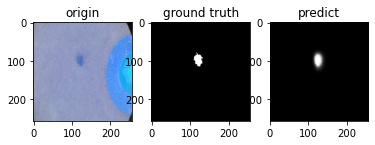

In [125]:
plt.subplot(1, 3, 1)
plt.title('origin')
plt.imshow(X_test[5])

plt.subplot(1, 3, 2)
plt.title('ground truth')
plt.imshow(Y_test[5],cmap='gray')

plt.subplot(1, 3, 3)
plt.title('predict')
plt.imshow(preds_img[5],cmap='gray')

plt.show()